### Import potentials and coordinates from HDF5 file

In [21]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import time

In [22]:
#Potential field are stored in a HDF5 file
f=h5py.File('PA_v4.hdf5','r')

In [23]:
for name in f:
    print name

Coordinates
Potential Arrays
iselectrode


In [24]:
#coordinates x,y,z in unit of mm
x=f["Coordinates/X"].value/2.
y=f["Coordinates/Y"].value/2.
z=f["Coordinates/Z"].value/2.

### Set electrodes potentials and calculate spatial potential values
19 electrodes are set to certain potentials to create electric field to ionize Rydberg atoms

In [5]:
#set values of 19 electrodes, for ionization field of state n=30
#electrode_set_potentials=[187.*1.2,187.*1.2,-1.74,-278.*1.2,-0.114*1.2,-1900.,0.,3.97*1.2,-1.74*1.2,-278.*1.2,187.*1.2,187.*1.2,0.3*1.2,-278.*1.2,0.,0.,0.,0.318*1.2,0.307*1.2];
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];

In [6]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.

### Interpolate potential arrays and plot cross sections for comparison

In [7]:
#generate potential interpolation

from scipy.interpolate import RegularGridInterpolator as rgi
p_interpolation=rgi((x,y,z),potentials)

#### MCP detector plane center

In [8]:
phi=-82.*np.pi/180.
tmatrix=np.array([[np.cos(phi),0,-np.sin(phi)],
           [0,1,0],
           [np.sin(phi),0,np.cos(phi)]])

#center point of MCP plane
center=(tmatrix.dot(np.array([0.,0.,3.]))*2 + [247,205,214])/2
#c=(241+6*np.cos(phi) + np.tan(- phi)*(247 + 6*np.sin( - phi)))/2.
c=center[2] + np.tan(- phi)* center[0]
center, c

(array([ 126.47080421,  102.5       ,  107.4175193 ]), 1007.3040503174313)

#### Define functions for single ion calculation

In [9]:
#single ion's position and velocity iteration functions

def R(ri,vi,dt):                  #delta_t in unit of micro-second, displacement in unit of mm, v in unit of mm/us
    x_new=ri[0]+vi[0]*dt
    y_new=ri[1]+vi[1]*dt
    z_new=ri[2]+vi[2]*dt
    return np.array([x_new,y_new,z_new])

def V(ri,vi,delta_t,dr):
    dvx=-100./(1.0364*87.) * (p_interpolation([ri[0]+dr,ri[1],ri[2]])[0]-p_interpolation([ri[0]-dr,ri[1],ri[2]])[0])/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1]+dr,ri[2]])[0]-p_interpolation([ri[0],ri[1]-dr,ri[2]])[0])/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1],ri[2]+dr])[0]-p_interpolation([ri[0],ri[1],ri[2]-dr])[0])/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

def VCoul(ra,rb):
    #coulombic acceleration of Rb ion at ra, due to repulsion of Rb ion at rb
    distance=np.linalg.norm(ra-rb)
    coulf=1.595 * 1.e-6 /distance**2
    return (ra-rb)*coulf/distance
    

def cross_ratio(r_n,r_iter,count,dt):
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    ratio=(r_p[0]-r_n[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    return r_new



def nstop(r):
    xx=r[0]
    zz=r[2]
    if (zz+np.tan(phi)*xx)< c :
        return True
    else:
        return False

**Distance step when calculating gradient has significant fluence on the trajectories**

In [10]:
dr=0.5       #dr[mm] is used when calculating gradients
dt=0.01     #dt[us]
v0=np.array([0,0,0])

In [11]:
def trajectory(r_init,v_init,dt):
    v_iter=np.zeros((1,3))
    r_iter=np.zeros((1,3))
    r_iter[0]=r_init
    v_iter[0]=v_init 
    count=0              #no appending?
    while (r_iter[-1]>[x[1],y[1],z[1]]).all() and (r_iter[-1]<[x[-2],y[-2],z[-2]]).all() and (r_iter[-1][2]-np.tan(phi)*r_iter[-1][0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        v_iter=np.append(v_iter,[V(r_iter[-1],v_iter[-1],dt,dr)],0)
        r_iter=np.append(r_iter,[R(r_iter[-1],v_iter[-1],dt)],0)
        count+=1
        if count*dt>20:
            break
        
    r=r_iter
    v=v_iter
    t=len(r_iter)*dt
    return [r,v,t]

def trajectory2(r_init,v_init,dt):
    r_iter=r_init
    v_iter=v_init 
    r_n=r_init
    count=0              #no appending?
    while (r_iter>[x[1],y[1],z[1]]).all() and (r_iter<[x[-2],y[-2],z[-2]]).all() and (r_iter[2]-np.tan(phi)*r_iter[0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        r_n=r_iter
        v_iter=V(r_iter,v_iter,dt,dr)
        r_iter=R(r_iter,v_iter,dt)
        count+=1
        if count*dt>13:
            break
        
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    v=v_iter
    ratio=(r_iter[0]-r_p[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    
    return [r_new,v]

def trajectories_two_ions(r_init1,v_init1,r_init2,v_init2,dt):
    r_iter1=r_init1
    v_iter1=v_init1
    r_iter2=r_init2
    v_iter2=v_init2
    r_n1=r_init1
    r_n2=r_init2
    count1=0
    count2=0
    #no appending?
    condition1=(r_iter1>[x[1],y[1],z[1]]).all() and (r_iter1<[x[-2],y[-2],z[-2]]).all() and (r_iter1[2]-np.tan(phi)*r_iter1[0]<=c)
    condition2=(r_iter2>[x[1],y[1],z[1]]).all() and (r_iter2<[x[-2],y[-2],z[-2]]).all() and (r_iter2[2]-np.tan(phi)*r_iter2[0]<=c)
    while condition1 or condition2:
        # while loop condition: ion still in effective volume, and not hit the plane
        iondistance=np.linalg.norm(r_iter1-r_iter2)
        """if iondistance<0.01:
            dt=0.0001
        else:
            dt=0.01"""
        if condition1:
            r_n1=r_iter1
            v_iter1=V(r_iter1,v_iter1,dt,dr) + (condition1 and condition2)*VCoul(r_iter1,r_iter2)*dt
            r_iter1=R(r_iter1,v_iter1,dt)
            count1+=1
        if condition2:
            r_n2=r_iter2
            v_iter2=V(r_iter2,v_iter2,dt,dr) + (condition1 and condition2)*VCoul(r_iter2,r_n1)*dt
            r_iter2=R(r_iter2,v_iter2,dt)
            count2+=1*condition2
        
        if max(count1*dt,count2*dt)>15:
            break
            
        condition1=(r_iter1>[x[1],y[1],z[1]]).all() and (r_iter1<[x[-2],y[-2],z[-2]]).all() and (r_iter1[2]-np.tan(phi)*r_iter1[0]<=c)
        condition2=(r_iter2>[x[1],y[1],z[1]]).all() and (r_iter2<[x[-2],y[-2],z[-2]]).all() and (r_iter2[2]-np.tan(phi)*r_iter2[0]<=c)
        
    #map coordinates into detector plane coordinate
    r_new1=cross_ratio(r_n1,r_iter1,count1,dt)
    r_new2=cross_ratio(r_n2,r_iter2,count2,dt)
    v1=v_iter1
    v2=v_iter2
    #displacement=np.array(r_new1) - np.array(r_new2)
    
    return [r_new1,v1,r_new2,v2]

#### Finding best starting point

In [12]:
#[r,v,t]=trajectory(r0,v0,dt)
r0=np.array([96.9,102.5,66.05])
#r0=np.array([97.,102.5,66.05])
v0=np.array([0,0,0])
t1=time.time()
[r,v]=trajectory2(r0,v0,dt)
t2=time.time()
print r

[2.7964238152028678, -0.11293771290986854, 6.5991370585118476]


Ion signal time delay change due to factor of voltages

In [25]:
factor=np.array([0.93,0.97,1.,1.05,0.95,0.87,1.2,0.96])
delay=np.array([6.7,6.3,6.,5.8,6.5,7.2,5.15,6.3])

In [26]:
tdelay=np.zeros(len(factor))

In [27]:
finalfactor=np.zeros((len(factor),3))
v=np.zeros((1,3))
r0=np.array([96.9,102.5,66.05])
for i in range(len(factor)):
    electrode_set_potentials[0] *= factor[i]
    electrode_set_potentials[1] *= factor[i]
    electrode_set_potentials[2] *= factor[i]
    electrode_set_potentials[3] *= factor[i]
    electrode_set_potentials[9] *= factor[i]
    electrode_set_potentials[10] *= factor[i]
    electrode_set_potentials[11] *= factor[i]
    electrode_set_potentials[12] *= factor[i]
    electrode_set_potentials[13] *= factor[i]
    potentials=np.zeros((len(x),len(y),len(z)))
    for k in range(19):
        electroden=f["Potential Arrays/electrode"+str(k+1)].value
        potentials+=electrode_set_potentials[k]*electroden/10000.
        
    p_interpolation=rgi((x,y,z),potentials)
    [finalfactor[i],v]=trajectory2(r0,v0,dt)
    electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];

In [28]:
finalfactor

array([[ 2.7705127 , -0.11016715,  6.81003771],
       [ 2.78456334, -0.11164212,  6.68395676],
       [ 2.79642382, -0.11293771,  6.59913706],
       [ 2.81297328, -0.11416144,  6.44896527],
       [ 2.77760525, -0.1114901 ,  6.7580752 ],
       [ 2.74522948, -0.10863147,  7.03305634],
       [ 2.8545967 , -0.11664789,  6.04227777],
       [ 2.78205365, -0.11110398,  6.71112306]])

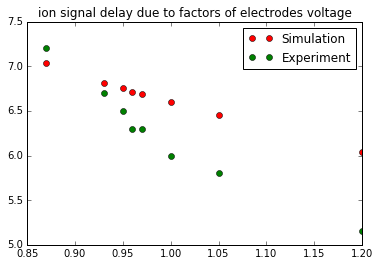

In [29]:
%matplotlib inline
plt.figure()
plt.plot(factor,finalfactor[:,2],'ro',label='Simulation')
plt.plot(factor,delay ,'go',label='Experiment')
plt.legend(loc='best')
plt.title("ion signal delay due to factors of electrodes voltage")
plt.show()

In [18]:
delay_simulation=finalfactor[:,2]
factor

array([ 0.93,  0.97,  1.  ,  1.05,  0.95,  0.87,  1.2 ,  0.96])

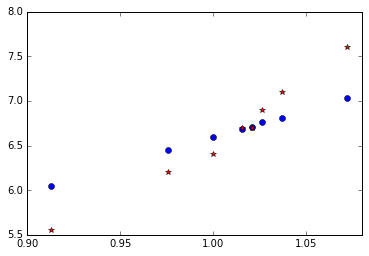

In [20]:
plt.plot(1/np.sqrt(factor),delay_simulation,'o')
plt.plot(1/np.sqrt(factor),delay + 0.4,'r*')

In [31]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(1/np.sqrt(factor),delay_simulation)
r_value

0.99966497564192403